In [1]:
import torch
import sklearn
import numpy as np
import deep_cluster.dataloader
from deep_cluster.dataloader import smooth, extract_coordinates
from pathlib import Path
import deep_cluster
import pandas as pd
from matplotlib import pyplot as plt
from landmarks_video import LandmarksVideo
from gui import Animation
import cv2 as cv
from PIL import Image
from scipy import signal as sig
import tkinter as tk
from PIL import ImageTk, Image
from itertools import product

import torch
from torch import nn

In [2]:
video_file = Path('/home/orel/Storage/Data/K7/2020-08-04/Down/0037.MP4')
video = LandmarksVideo(video_file.parent, smooth=False)
df = video.landmarks.df
body_parts = video.landmarks.body_parts
body_parts = body_parts[~(body_parts == 'tail2')]

df['confidence'] = np.prod(np.stack([df[bp].likelihood.values for bp in body_parts]), axis=0)
# high_confidence_bool = np.logical_and(df.confidence > 0.99, smooth(df.confidence, lpf_freq=1.0, fs=video.fps) > 0.99)
idxs = np.where(df.confidence > 0.99)[0]
segments = np.split(idxs, np.where(np.diff(idxs) > 1)[0] + 1)
segments = [seg for seg in segments if len(seg) > 120 * 3]

In [3]:
class LandmarksData(torch.utils.data.Dataset):
    def __init__(self, data, body_parts=None, seqlen=60, step=20):
        super(LandmarksData, self).__init__()
        self.data = data.astype(np.float32)
        if body_parts is None:
            body_parts = list(df.columns)
        self.body_parts = body_parts
        self.seqlen, self.step = seqlen, step
        
    def __len__(self):
        return (len(self.data) - self.seqlen) // self.step
    
    def __getitem__(self, idx):
        return self.data[idx * self.step: idx * self.step + self.seqlen]
    
def get_data(df, segments, seqlen=60, step=20):
    coords = extract_coordinates(df, normalize=True)
    N, n_points, dim = coords.shape
    coords = coords.reshape((N, n_points*dim))
    coords = (coords - coords.mean()) / (coords.std() + 1e-8)
    return torch.utils.data.ConcatDataset([LandmarksData(coords[seg], body_parts, seqlen=seqlen, step=step) for seg in segments])
    
len(get_data(video.normalized_landmarks.df[body_parts], segments))

4649

In [93]:
dl = torch.utils.data.DataLoader(get_data(video.normalized_landmarks.df[body_parts], segments[20:]), batch_size=16)
next(iter(dl)).shape

torch.Size([16, 60, 38])

In [ ]:
?torch.stac

In [57]:
class ParralelApply(nn.Module):
    def __init__(self, layer, dim=1):
        super(ParralelApply, self).__init__()
        self.layer = layer
        self.dim = dim
        
    def forward(self, x):
        bs, seqlen, dim = x.shape
        return self.layer(x.reshape(bs*seqlen, dim)).reshape(bs, seqlen, -1)
#         _xs = x.unbind(dim=self.dim)
#         _out = [self.layer(_x) for _x in _xs]
#         return torch.stack(_out, dim=self.dim)
        
class SimpleLM(nn.Module):
    def __init__(self, input_size=38, hidden_size=256, num_layers=3):
        super(SimpleLM, self).__init__()
        self.inp = ParralelApply(nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU()))
        self.rnn = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.out = ParralelApply(nn.Linear(hidden_size, input_size))
        
    def forward(self, x):
        bs, seqlen, dim = x.shape
        x = self.inp(x)
        rnn_out, h_n = self.rnn(x)
        return self.out(rnn_out)
    
    def loss(self, x):
        out = self.forward(x[:-1])
        return ((out - x[1:]) ** 2).mean()

    
class SimpleLM1(nn.Module):
    def __init__(self, input_size=38, hidden_size=256, num_layers=3):
        super(SimpleLM1, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.out = ParralelApply(nn.Linear(hidden_size, input_size))
        self.out.layer.bias.data.zero_()
        self.out.layer.weight.data.zero_()
        
    def forward(self, x):
#         x = self.inp(x)
        rnn_out, h_n = self.rnn(x)
        return x + self.out(rnn_out)
    
    def loss(self, x):
        out = self.forward(x[:-1])
        return ((out - x[1:]) ** 2).mean()

# class SimpleLM(nn.Module):
#     def __init__(self, input_size=38, hidden_size=256, num_layers=3):
#         super(SimpleLM, self).__init__()
#         self.inp = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
#         self.rnn = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         self.out = nn.Linear(hidden_size, input_size)
        
#     def forward(self, x):
#         bs, seqlen, dim = x.shape
#         x = self.inp(x.reshape(bs*seqlen, -1)).view(bs, seqlen, -1)
#         rnn_out, h_n = self.rnn(x)
#         return self.out(rnn_out.reshape(bs*seqlen, -1)).view(bs, seqlen, dim)
    
#     def loss(self, x):
#         out = self.forward(x[:-1])
#         return ((out - x[1:]) ** 2).mean()

class CopyLM(nn.Module):
    def __init__(self):
        super(CopyLM, self).__init__()
        self.param = nn.Parameter(torch.zeros(1), requires_grad=True)
        
    def forward(self, x):
        return x + self.param - self.param
    
    
lm = SimpleLM()

In [19]:
copy_lm = CopyLM().cuda()
fit_lm(copy_lm, epochs=2)

0 tensor(6.5297e-06, device='cuda:0')
1 tensor(6.5297e-06, device='cuda:0')


In [65]:
dl = torch.utils.data.DataLoader(get_data(video.normalized_landmarks.df[body_parts], segments[:30]), batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(get_data(video.normalized_landmarks.df[body_parts], segments[-5:]), batch_size=16)

def fit_lm(lm, lr=3e-4, epochs=50):
    opt = torch.optim.AdamW(lm.parameters(), lr=lr, weight_decay=0.1)
    losses = []
    test_losses = []
    for i_epoch in range(epochs):
        for bx in dl:
            bx = bx.cuda()
            inp = bx[:,:-1]
            out = lm(inp)
            loss = (out - bx[:,1:]).abs().mean()
            losses.append(loss)
            opt.zero_grad()
            loss.backward()
            opt.step()
        with torch.no_grad():
            test_loss = 0
            for bx in test_dl:
                bx = bx.cuda()
                out = lm(bx[:, :-1])
                loss = ((out - bx[:, 1:]) ** 2).mean()
                test_loss += loss / len(test_dl)
            print(i_epoch, test_loss)
            test_losses.append(test_loss)
            
lm = SimpleLM1(hidden_size=256, num_layers=3).cuda()
fit_lm(lm, lr=1e-5)

0 tensor(6.5454e-06, device='cuda:0')
1 tensor(6.5304e-06, device='cuda:0')
2 tensor(6.5287e-06, device='cuda:0')
3 tensor(6.5246e-06, device='cuda:0')
4 tensor(6.5493e-06, device='cuda:0')
5 tensor(6.5148e-06, device='cuda:0')
6 tensor(6.5166e-06, device='cuda:0')
7 tensor(6.5066e-06, device='cuda:0')
8 tensor(6.5040e-06, device='cuda:0')
9 tensor(6.5322e-06, device='cuda:0')
10 tensor(6.5080e-06, device='cuda:0')
11 tensor(6.4732e-06, device='cuda:0')
12 tensor(6.5247e-06, device='cuda:0')
13 tensor(6.4719e-06, device='cuda:0')
14 tensor(6.5277e-06, device='cuda:0')
15 tensor(6.5096e-06, device='cuda:0')
16 tensor(6.4990e-06, device='cuda:0')
17 tensor(6.5298e-06, device='cuda:0')
18 tensor(6.5477e-06, device='cuda:0')
19 tensor(6.4312e-06, device='cuda:0')
20 tensor(6.4495e-06, device='cuda:0')
21 tensor(6.5057e-06, device='cuda:0')
22 tensor(6.5344e-06, device='cuda:0')
23 tensor(6.4466e-06, device='cuda:0')
24 tensor(6.4588e-06, device='cuda:0')
25 tensor(6.5301e-06, device='cuda:

In [50]:
bx[idx].std(dim=0)

tensor([0.0550, 0.0000, 0.0466, 0.0445, 0.0167, 0.0478, 0.0189, 0.0381, 0.0223,
        0.0509, 0.0249, 0.0434, 0.0145, 0.0530, 0.0145, 0.0438, 0.0105, 0.0318,
        0.0070, 0.0169, 0.0084, 0.0271, 0.0150, 0.0329, 0.0140, 0.0365, 0.0173,
        0.0330, 0.0254, 0.0334, 0.0187, 0.0302, 0.0000, 0.0000, 0.0071, 0.0069,
        0.0052, 0.0445])

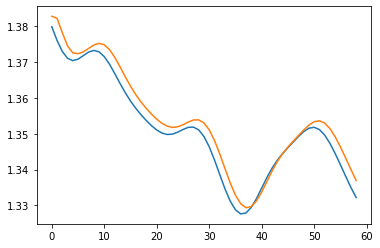

In [53]:
ds = get_data(video.normalized_landmarks.df[body_parts], segments[30:-5])
bx = next(iter(test_dl))
lm = lm.cpu()
with torch.no_grad():
    out = lm(bx[:,:-1])
idx = 2
plt.plot(bx[idx][1:,12].numpy())
plt.plot(out[idx][:,12].numpy())

In [175]:
((bx[:,1:] - bx[:,:-1]) ).abs().mean()

tensor(0.0032)

In [216]:
((bx[:,1:] - out) ).mean(dim=(0,1))

tensor([ 0.2375,  0.0111,  0.2520, -0.0084,  0.0265, -0.0605, -0.0961,  0.1062,
         0.1050,  0.0543,  0.1277,  0.0089,  0.0903,  0.0019,  0.0645, -0.0168,
         0.0389, -0.0211, -0.0148,  0.0483,  0.2887, -0.0848,  0.1630, -0.0345,
         0.1060, -0.0849, -0.0136,  0.0781, -0.1768,  0.1019, -0.1774,  0.1674,
        -0.0043,  0.0118,  0.0592, -0.0393,  0.1117,  0.2411])

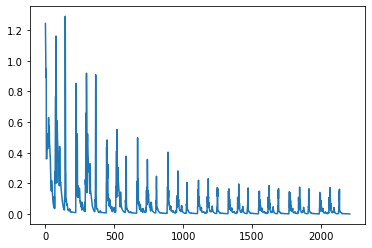

In [119]:
plt.plot(losses)

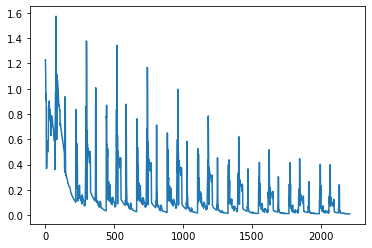

In [109]:
plt.plot(losses)